In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
from photutils import create_matching_kernel
from skimage.transform import downscale_local_mean
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import numpy as np


import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import ndimage
from PIL import Image


def radec2xy(ra,dec,wc):
    coords = SkyCoord(ra,dec, unit='deg')
    a=wcs.utils.skycoord_to_pixel(coords, wc, origin=0,mode=u'wcs')
    return a[0],a[1]
    
def cut(ra,dec,andaze,filename):
    '''gets coordinates of the galaxy and the filter to return a cutout
    (also called a postage stamp) of the galaxy with given size'''
    hdr = pyfits.getheader(filename)
    w = wcs.WCS(hdr)
    x,y=radec2xy(ra,dec,w)
    x,y=np.int(x),np.int(y)
    im=pyfits.getdata(filename)[y-andaze:y+andaze,x-andaze:x+andaze]
    return im

def brightest_center(im, r = 10):
    
    '''This function is to check whether the central object of the 
    image is the brightest compared to its neighbors in the given cutout.
    Central is defined with a 10x10 pixel square in the center'''
    
    a0,a1 = np.unravel_index(np.argmax(im, axis=None), im.shape)
    ans = False
    if ((a0>((im.shape[0]-r)/2)) & (a0<((im.shape[0]+r)/2)) & (a1>((im.shape[1]-r)/2)) & (a1<((im.shape[0]+r)/2))):
        ans = True
    
    return ans
 
def galblend(gals=1, lim_hmag=24, plot_it=True):
    
    '''This is to put together two candels GOODS_S galaxies into a single 64x64 cutout.
    I make sure in each cutout the central galaxy is brightest object in the cutout so 
    in rescaling and adding two components still show up. Also, one galaxy is put at 
    the center and the second in some random distance from it. both cutouts are rotated with
    a random angle. Cutouts are from HST H band for now.'''
    
    ## reading GOODS-S catalog and initial selection on objects
    gs = pyfits.getdata('../../WFIRST_WPS/CANDELS_fits/gds.fits')
    sel1 = (gs['zbest']>0.1)&(gs['zbest']<5.0)&(gs['CLASS_STAR']<0.95)&(gs['Hmag']<lim_hmag)&(gs['FWHM_IMAGE']>2)
    ra, dec,red = gs['RA_1'][sel1],gs['DEC_1'][sel1],gs['zbest'][sel1]
    
    im = np.zeros([64,64])
   
    data1 = np.zeros([80,80])
    da1 = np.zeros([64,64])
    while not(brightest_center(data1)):
        n = np.int(np.random.uniform(0,len(ra)-1))
        data1 = cut(ra[n],dec[n],40,'/Users/shemmati/Desktop/GOODS/goodss_all_wfc3_ir_f160w_060mas_v1.0_drz.fits')
        z1 = red[n]
    
    angle = np.random.uniform(0,180)
    s = ndimage.rotate(data1,angle,mode='nearest',reshape=False)
    da1 = s[8:-8,8:-8]
    im += da1
    
    da2 = np.zeros([gals,64,64])
    z2 = np.zeros(gals)
    for boz in range(gals-1):
        data2 = np.zeros([100,100])
        while not(brightest_center(data2)):
            n = np.int(np.random.uniform(0,len(ra)-1))
            data2 = cut(ra[n],dec[n],50,'/Users/shemmati/Desktop/GOODS/goodss_all_wfc3_ir_f160w_060mas_v1.0_drz.fits')
            z2[boz] = red[n]
        p,t = np.int(np.random.uniform(5,10)),np.int(np.random.uniform(5,10))
        s = data2[10+t:-10+t,10+p:-10+p]
        angle = np.random.uniform(0,180)
        so = ndimage.rotate(s,angle,mode='nearest',reshape=False)
        da2[boz] = so[8:-8,8:-8]
    
        im += da2[boz]
    
        
    dada = np.arcsinh(im)
    rescaled = (255.0 / (dada.max()+0.05) * (dada - dada.min())).astype(np.uint8)
    final_im = Image.fromarray(rescaled)
        
    if plot_it:
        plt.figure(figsize=(15,6))
        n = gals+1
        
        plt.subplot(1,n,1)
        plt.imshow(da1,origin='lower')
        plt.text(2,55,'1, z='+str(z1),color='y')
        for boz in range(gals-1):
            plt.subplot(1,n,2+boz)
            plt.imshow(da2[boz],origin='lower')
            plt.text(2,55,str(boz+2)+', z='+str(z2[boz]),color='y')
        plt.subplot(1,n,n)
        plt.imshow(dada,origin='lower')
        plt.text(2,55,'Sum',color='y')
        plt.show()
    return final_im,rescaled

%matplotlib inline

In [2]:
batchSize = 64          # input batch size
imageSize = 64           # the height / width of the input image to network
ngf = 64
ndf = 64
nz = 100
ngpu = 3       #number of GPUs to use
netG = ''
manualSeed = random.randint(1, 10000)

torch.manual_seed(manualSeed)
device = torch.device("cpu")

nc = 1

class Shoobygen(nn.Module):

    def __init__(self,ngpu):
        super(Shoobygen, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.Conv2d(1, ngf * 4, 7, 2, 2, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            nn.ConvTranspose2d( ngf*4, ngf * 2, 6, 3, 2,dilation=2, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 2, nc, 3, 2, 2, bias=False),
           # nn.BatchNorm2d(ngf * 4),
           # nn.ReLU(True),
  
            #nn.ConvTranspose2d(ngf*4, nc, 4, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
            output1 = output[:,:,:,:]

        else:
            output = self.main(input)
            output1 = output[:,:,:,:]

        return output1


netS = Shoobygen(ngpu).to(device)
netS.load_state_dict(torch.load('netG_blended_700.pth',map_location='cpu'))


<All keys matched successfully>

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


torch.Size([1, 1, 65, 65])


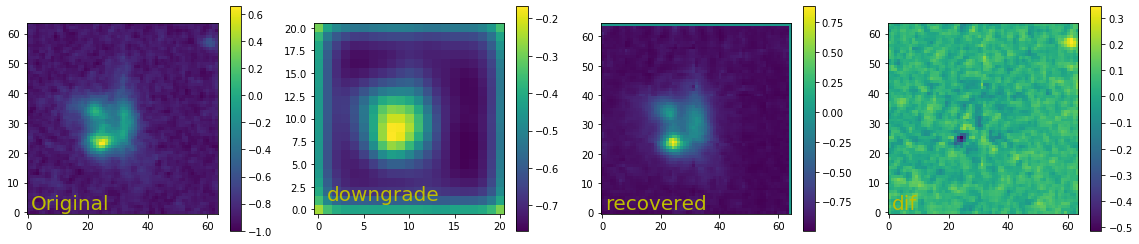

In [18]:
a,galax = galblend(gals=3,lim_hmag=24,plot_it=False)

#### images need to be normalized before seeing GAN#########
# from torchvision import transforms
# transforms.normalize(0.5,0.5)(gals)
tfms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
im = tfms(galax)
############################################################
#converting to pytorch tensor with the right size
gals = np.repeat(im[:,:,:,np.newaxis],1,axis = 3)
gals =torch.tensor(gals, device="cpu").float()
gals = gals.permute(3,0,1,2)

inputs = gals
real_cpu = inputs.to(device)
ajab = real_cpu.detach()


## Make Kernel
psf = pyfits.getdata('psf_i.fits')
psf = downscale_local_mean(psf,(3,3))
psf = psf[7:-8,7:-8]#[22:-22,22:-22]

psf_hsc = pyfits.getdata('psf-calexp-s16a_wide-HSC-I-15827-7,2-236.00000-42.00000.fits')
psf_hsc = psf_hsc[0:41,1:42]

kern = create_matching_kernel(psf,psf_hsc)
psfh = np.repeat(kern[:,:, np.newaxis], 1, axis=2)
psfh = np.repeat(psfh[:,:,:,np.newaxis],1,axis = 3)
kernel = torch.Tensor(psfh)
kernel = kernel.permute(2,3,0,1)
kernel =  kernel.float()
kernel = kernel.to(device)

## add noise, downsample, convolve with kernel ---> give to GAN
im = real_cpu+0.25*torch.rand_like(real_cpu)
downsampled = F.upsample(im,scale_factor=1/3,mode='bilinear')
img = F.conv2d(downsampled, kernel,padding=int(((kernel.shape[3])-1)/2))
img = img[:,:,:,:]


fake = netS(img)
print(fake.shape)
fd = fake.detach()
fd = fd.cpu()

plt.figure(figsize=(16,3.5))
plt.subplot(1,4,1)
plt.imshow(ajab[0,0,:,:],origin='lower')
plt.colorbar()
plt.text(1,1,'Original',color='y',size=20)
plt.subplot(1,4,2)
plt.imshow(img[0,0,:,:],origin='lower')
plt.colorbar()
plt.text(1,1,'downgrade',color='y',size=20)
plt.subplot(1,4,3)
plt.imshow(fd[0,0,:,:],origin='lower')
plt.colorbar()
plt.text(1,1,'recovered',color='y',size=20)
plt.subplot(1,4,4)
plt.imshow(ajab[0,0,:,:]-fd[0,0,:-1,:-1],origin='lower')
plt.colorbar()
plt.text(1,1,'dif',color='y',size=20)

plt.tight_layout()